# Capstone Project: Deep Learning, Milestone 2
## Identification of Plasmodium spp. from Thin Blood Smears using Deep Learning.
*Malaria diagnosis is performed as a thin blood smear by a Parasitologist with specialized training. There currently exists a need to have an alternative method to read blood smear slides for the detection of Malaria. The goal is to build a computer vision model that is successful at identifying Malaria infections at the species level collection of infected and uninfected blood smears would need to be analyzed for key features.*

### **Problem Definition**
#### *Context*
The number of certified Parasitology Microbiologists with the skill and expertise to read blood smear slides for Malaria is rapidly diminishing and the technical expertise is evaporating.  To best solve this subject matter gap it is proposed to *create a predictive algorithm to detect a Plasmodium spp. at any stage of the parasite life cycle among normal red blood cells?*  Can the model be further trained to speciate the detected Plasmodium spp. based on key features in the parasite morphology?

#### *Objectives*
Building a Convolutional Neural Network is the next step, the model should flatten and pool the dense layers trained over several epochs and model iterations to yield a high-performing model with a high degree of accuracy. False negative samples could have serious health outcomes including mortality thus precision and accuracy must match or exceed the accuracy rate of traditional light microscopy.

#### *Key Questions*
Can the system be trained to report the presence or absence of the *Plasmodium* parasite in blood smear images? What is the optimized model to detect the parasite that yields a high confidence result with accuracy and reproducibility?    

#### *Problem formulation*
*  Images are thin blood smears stained with Giemsa-Wright stain.  This is a differential stain in which the parasite stains a different color than the red blood cells and extracellular debris.  
* Use of uninfected smears will allow training to healthy normal red blood cells (RBC).  This training should permit early detection of RBC distortions capturing parasites at the Gametophyte stage.  This is particular to aid in the detection of *Plasmodium falciparum*.  
*  The edges of parasite structures can be defined using the known blue to purple color for the staining of the parasite.  Flattening the color range to highlight the parasite from background cell debris and healthy cells.

## **Methods**
### **Data Exploration**
This data set contains a series of thin blood smear images stained with the Giemsa-Wright differential stain for the detection of Malaria. The dataset is divided into training and test images, further organized, and labeled as 'Uninfected' or 'Parasitized'. The data source is a trusted source.

**Mount the Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Library Import**

### Dataset
To evaluate the data parameters the data stored in the zip file must be extracted and read data into a DataFrame.  Then it is possible to evaluate the data for the dimensions and size.  Additionally, the data should be examined for missing values, normalizing the data, and consistency in language.

In [3]:
#Data Handling library
import numpy as np
import pandas as pd

#Graphing library
import matplotlib.pyplot as plt
%matplotlib inline

#Data Visualization library
import seaborn as sns
sns.set_color_codes(palette='dark')
sns.dark_palette=('seagreen')

#Machine Learning library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Suppress Python Library depreciation warnings
import warnings
warnings.filterwarnings('ignore')

#Set maximum size of pandas DataFrame
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

In [4]:
#The dataset is named 'cell_images.zip' and is located in the Colab Notebooks/Capstone Project file.  
#The data is provided as a zip file that requires unzipping.  Load zipfile to open data set.
import zipfile
import os

#File location to be read
path='/content/drive/MyDrive/Colab Notebooks/Capstone Project/cell_images.zip'

#Extract data files from zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
#Model Building library
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Input, Flatten, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.utils import to_categorical

print(tf.__version__)

2.9.2


In [6]:
#Import Pillow Library as PIL for image processing
from PIL import Image

## **Exploratory Data Analysis**
**Processing Image Data**

The images should be evaluated for image format consistency, image size and dimension, and pixel depth.  This can be accomplished using the Python library Pillow, an image processing library specifically with the capability to perform color space conversions, image resizing, and contrast enhancement.

In [7]:
#Assigning train data for infected and uninfected 
train_dir='/content/cell_images/train/'

#Designate image size for normality across data set.
SIZE=64

#Create list containers for the image data
train_images=[]

#Create a list container for Boolean value indicating infection state (0:uninfected, 1:infected)
train_label=[]

#Loading Training data into List
for folder_name in ['/parasitized/','/uninfected/']:
  images_path=os.listdir(train_dir + folder_name)
  for i, image_name in enumerate(images_path):
    try:
      #Open each image in sequence as exception coding
      image=Image.open(train_dir + folder_name + image_name)
      #Resize Images to 64x64 to standardize to same shape
      image=image.resize((SIZE,SIZE)) 
      #Convert the images to list 'train_images' as designated above
      train_images.append(np.array(image))
      #Create the infected and uninfected labels with conditional logic
      if folder_name=='/parasitized/':
        train_label.append(1)
      else:
        train_label.append(0)
    except Exception:
      pass

#Convert list above into NumPy Array
train_images=np.array(train_images)
train_label=np.array(train_label)

In [8]:
#Assigning test data for infected and uninfected 
test_dir='/content/cell_images/test/'

#Designate image size for normality across data set.
SIZE=64

#Create list containers for the image data
test_images=[]

#Create a list container for Boolean value indicating infection state (0:uninfected, 1:infected)
test_label=[]

#Loading Test data into List
for folder_name in ['/parasitized/','/uninfected/']:
  images_path=os.listdir(test_dir + folder_name)
  for i, image_name in enumerate(images_path):
    try:
      #Open each image in sequence as exception coding
      image=Image.open(test_dir + folder_name + image_name)
      #Resize Images to 64x64 to standardize to same shape
      image=image.resize((SIZE,SIZE)) 
      #Convert the images to list 'train_images' as designated above
      test_images.append(np.array(image))
      #Create the infected and uninfected labels with conditional logic
      if folder_name=='/parasitized/':
        test_label.append(1)
      else:
        test_label.append(0)
    except Exception:
      pass

#Convert list above into NumPy Array
test_images=np.array(test_images)
test_label=np.array(test_label)

In [9]:
#Pass NumPy Array to Pandas DataFrame
df_train=pd.DataFrame(train_label, columns=['Infection_Status'])

**Data Preparation**<br>
To prepare the images for machine learning the data shape and array must be determined.  The data must then be normalized to ensure each pixel has a similar distribution.

In [10]:
#Normalize the data.  There are 255 pixels thus all data will be normalized by dividing by 255.
train_images = (train_images/255).astype('float32')
test_images = (test_images/255).astype('float32')

###One Hot Encoding on the train and test labels
Categorical data seen in the labels identifying the infection status must be converted into vector array.  This conversion makes the data scalable, converting the string data 'Parasitized' and 'Uninfected' into numerical values that can be read by the machine learning model.  This vectorized format is easily read by the machine learning algorithm. 

In [11]:
# Encoding Train Labels
train_label = to_categorical(train_label, 2)

# Similarly let us try to encode test labels
test_label = to_categorical(test_label, 2)

#Visualize the new vector array
print(train_label)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


### **Base Model**

The basic model will take the input layer and pass the image data through hidden layer neurons as specified in the model.  The data is passed then to an output layer which processes the data and returns an output to the model.  

In [12]:
# Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

### Building the Model
The Convolutional Neural Network (CNN) is a series of operations applied to an input image that translates the information into a machine learning algorithm creating a predictive analytic from trainable features.  Images are two dimensional and the Conv2D will designate each layer in the model.  The CNN is comprised of multiple layers, each building on the previous to extract the key features and allow interpretation of those features using labels in the data. 

The base layer begins a class that passes the attributes to each layer.  To find the ideal parameters to apply to the images in the dataset layers are created that allow the model to interpret the values.  
* Core layers include activations designate the functions used to generate the tensors passed to the hidden layers in the next layer of neurons. In particular the relu function is a rectified linear activation function that generates a max value based on the input shapes.  
* Dense layers act as core layers of the CNN generated by the dot product of the input matrix and kernel, designating the dimensionality of the output space. Filters designate the number of output filters in each convolution while the kernel size specifies the height and width of the convolutional window.  
* Pooling layers use the input height and width to return the maximum value from the designated window size allowing the window to shift with each dimension in the input layers. 

* Normalization layers normalize the continuous features by scaling and/or shifting inputs based on the mean values and variance.  This acts as a background subtraction allowing weight to be added to significant values.  
* Regularization layers randomly assign zero input values to help prevent overfitting during training.  
* Reshaping layers
These methods include flattening which reshape the input thereby reflecting a change in the dimensionality of the output. 

In [13]:
# Creating sequential model
def cnn_model():
  model = Sequential()
  model.add(Conv2D(filters = 32, kernel_size = 2, 
                   padding = "same", 
                   activation = "relu", 
                   input_shape = (64, 64, 3)))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters = 32, kernel_size = 2, 
                   padding = "same", 
                   activation = "relu"))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters = 32, kernel_size = 2, 
                   padding = "same", 
                   activation = "relu"))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(512, activation = "relu"))

  model.add(Dropout(0.4))
  model.add(Dense(2, activation = "softmax")) #Output Layer Neurons: 2 

#Compile
  model.compile(
      loss = 'binary_crossentropy', 
      optimizer = 'adam',
      metrics = ['accuracy'])
  return model

#Build the model
model=cnn_model()

#Print Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

### Compiling the Model Observations
Loss functions act to compute the value that a model should seek to minimize during training.  Binary crossentropy compares the predicted probability distribution to the actual output from the model.  This becomes a penalty score based on the difference of the calculated probabilities from the expected value.  The close these values are to the actual value, the better the predictions from the model.  To calculate success of the model and locate improvement, it is expected to see a training accuracy as close to 100% as possible with minimal loss.

### *Using Callbacks*
Callbacks are a series of methods that allow periodic saving of the model to a disk when data sets are large as seen in the total trainable parameters above.  The use of early stopping allows the model to fit, stopping the number of iterations of the model when a specified parameter such as validation loss does not incrementally change by a specified amount during each epoch.  This stopping indicates a point at which no additional training can be achieved without considerable loss to the model.  EarlyStopping also prevents excessive use of computing power when the model is at peak efficiency.  The patience score designates how many additional epoch cycles the model will perform before early termination.  When there is no further improvement in the model, the training stops.  

In [14]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

### Fit and Train the Model
Fitting and training the data to the model uses the methods designated in the algorithm and begins to apply each technique to the layers.  The algorithm uses incremental performance processing a designated number of samples each iteration until all the samples are processed.  The batch size affects the speed of the model as well as the performance.  The total number of samples designated in the batch size are loaded into the memory and the larger the batch size the more memory required to process each layer.  A balance between the number of samples in the batch must be achieved with the number of epochs to achieve the optimal efficiency and accuracy of the model.  Smaller batch sizes process more quickly but with lower accuracy.


In [15]:
# Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
history = model.fit(train_images, 
                    train_label, 
                    batch_size = 64, 
                    callbacks = callbacks, 
                    validation_split = 0.2, 
                    epochs = 20, 
                    verbose = 1)

Epoch 1/20
312/312 [==============================] - 96s 303ms/step - loss: 0.5530 - accuracy: 0.7157 - val_loss: 0.2655 - val_accuracy: 0.9058
Epoch 2/20
312/312 [==============================] - 89s 284ms/step - loss: 0.1543 - accuracy: 0.9391 - val_loss: 0.1148 - val_accuracy: 0.9724
Epoch 3/20
312/312 [==============================] - 91s 292ms/step - loss: 0.1202 - accuracy: 0.9572 - val_loss: 0.1023 - val_accuracy: 0.9868
Epoch 4/20
312/312 [==============================] - 87s 279ms/step - loss: 0.0990 - accuracy: 0.9670 - val_loss: 0.0676 - val_accuracy: 0.9914
Epoch 5/20
312/312 [==============================] - 91s 292ms/step - loss: 0.0883 - accuracy: 0.9705 - val_loss: 0.0863 - val_accuracy: 0.9864
Epoch 6/20
312/312 [==============================] - 89s 287ms/step - loss: 0.0800 - accuracy: 0.9736 - val_loss: 0.0633 - val_accuracy: 0.9902
Epoch 7/20
312/312 [==============================] - 92s 295ms/step - loss: 0.0727 - accuracy: 0.9757 - val_loss: 0.1073 - val_ac

## Evaluating the Model on Test Data
It is expected that a minimum of 90% should be achieved for the base model.  This allows room to improve the model through adjustment of the batch size, callback parameters, and number of layers.  

In [16]:
accuracy = model.evaluate(test_images, test_label, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 3s 38ms/step - loss: 0.0726 - accuracy: 0.9815

 Test_Accuracy:- 0.9815384745597839


### Plotting the Confusion Matrix
The test accuracy was calculated indicating the model can correctly identify the presence of a parasite infection at least 98.5% accuracy.  This should be supported in the confusion matrix through a high degree of accuracy and values for predicted and actual that are similar.  The goal is to have the prediction and actual values as close as possible.  

82/82 [==============================] - 3s 38ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1300
           1       0.97      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



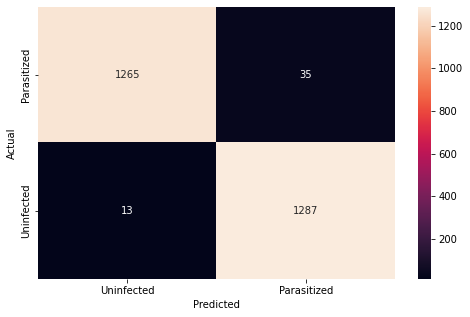

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_label, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', 
            xticklabels = ['Uninfected', 'Parasitized'], 
            yticklabels = ['Parasitized', 'Uninfected'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The model predicts the presence of the parasite with 97% precision indicating a high connection between the trainable key features used to identify the parasite in blood smears.  The recall shows the model can correctly identify the parasite despite variability in the images which could include cellular debris.  The F1 score demonstrates the precision and accuracy in predictions.  A high F1 score indicates high precision in the predictions made by the algorithm.  There is a concern that fifteen additional samples were predicted to contain parasites while the actual number of infected samples is lower.  This could result in treatment being prescribed that would otherwise be detrimental to the health status of a healthy person.

### Plotting and Training Validation Curves


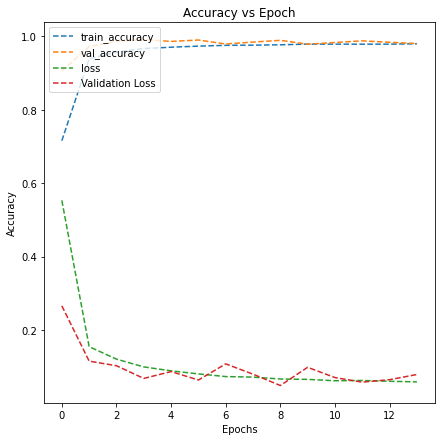

In [18]:
# Function to plot train and validation accuracy 
def plot_accuracy(history):
    N = len(history.history["accuracy"])
    plt.figure(figsize = (7, 7))
    plt.plot(np.arange(0, N), history.history["accuracy"], 
             label = "train_accuracy", ls = '--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], 
             label = "val_accuracy", ls = '--')
    plt.plot(np.arange(0, N), history.history["loss"], 
             label = "loss", ls = '--')
    plt.plot(np.arange(0, N), history.history["val_loss"], 
             label = "Validation Loss", ls = '--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

plot_accuracy(history)

**Observations**
* Comparison of the training accuracy to the validation accuracy shows a similar curve pattern to the training model for the test data.  The model seems to have a similar performance from roughly five cycles through to the end.  
* This particular model was stopped early at 14 epochs.  
* As the accuracy of the models improves the loss function and validation loss function decline logrithmically, tapering to below 0.2 by five epochs.  As the model continues to perform across the twenty epochs, the loss function remains minimized.  This data suggests the model is a good fit for the data.
* The next model should expand on this base model to improve the precision and accuracy.  This can be achieved by adding layers to the existing model.  Adding a fourth convolutional layer, pooling layer, core layer as dense, and dropout layer should improve the fitness of the model without overfitting.

### **Model 1**
To expand on the base model additional layers can be added to improve performance.  In the base model the batch size was structured to 64 images per batch which is balanced between compute engine use and model performance.  
* Add a fourth convolutional layer to the model.  This will add an additional tensor of outputs.  
* Add a max pooling layer to find the maximum values and exploit key features.  
* Add dropout layer to prevent overfitting.


In [19]:
backend.clear_session() # Clearing the backend for new model

In [20]:
# Creating sequential model
def cnn_model_1():
  model = Sequential()
  #First Convolutional Layer
  model.add(Conv2D(filters = 32, kernel_size = 2, 
                   padding = "same", 
                   activation = "relu", 
                   input_shape = (64, 64, 3)))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.2))
  #Second Convolutional Layer
  model.add(Conv2D(filters = 32, kernel_size = 2, 
                   padding = "same", activation = "relu"))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.2))
  #Third Convolutional Layer
  model.add(Conv2D(filters = 32, kernel_size = 2, 
                   padding = "same", activation = "relu"))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.2))
  #Fourth Convolutional Layer
  model.add(Conv2D(filters = 64, kernel_size = 2, 
                   padding = "same", activation = "relu"))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.2))
  
  #Flatten previous layer
  model.add(Flatten())
  #Add Density Layer
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(0.4))
  
  #Output Layer
  model.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

  #Compile
  model.compile(
      loss = 'binary_crossentropy', 
      optimizer = 'adam',
      metrics = ['accuracy'])
  return model

#Build the model
model_1=cnn_model_1()

#Print Model Summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

In [21]:
#Callback
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

In [22]:
#Fit and train the model
history_1 = model_1.fit(train_images, 
                    train_label, 
                    batch_size = 64, 
                    callbacks = callbacks, 
                    validation_split = 0.2, 
                    epochs = 20, 
                    verbose = 1)

Epoch 1/20
312/312 [==============================] - 94s 298ms/step - loss: 0.5081 - accuracy: 0.7381 - val_loss: 0.2806 - val_accuracy: 0.9475
Epoch 2/20
312/312 [==============================] - 89s 285ms/step - loss: 0.1049 - accuracy: 0.9644 - val_loss: 0.0751 - val_accuracy: 0.9882
Epoch 3/20
312/312 [==============================] - 93s 297ms/step - loss: 0.0880 - accuracy: 0.9714 - val_loss: 0.0826 - val_accuracy: 0.9820
Epoch 4/20
312/312 [==============================] - 88s 282ms/step - loss: 0.0800 - accuracy: 0.9724 - val_loss: 0.0368 - val_accuracy: 0.9912
Epoch 5/20
312/312 [==============================] - 97s 311ms/step - loss: 0.0733 - accuracy: 0.9755 - val_loss: 0.0732 - val_accuracy: 0.9802
Epoch 6/20
312/312 [==============================] - 104s 335ms/step - loss: 0.0725 - accuracy: 0.9761 - val_loss: 0.0434 - val_accuracy: 0.9880
Epoch 7/20
312/312 [==============================] - 92s 294ms/step - loss: 0.0666 - accuracy: 0.9775 - val_loss: 0.0718 - val_a

In [23]:
#Evaluate the model
accuracy = model_1.evaluate(test_images, test_label, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 3s 37ms/step - loss: 0.0531 - accuracy: 0.9842

 Test_Accuracy:- 0.9842307567596436


82/82 [==============================] - 3s 37ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1300
           1       0.98      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



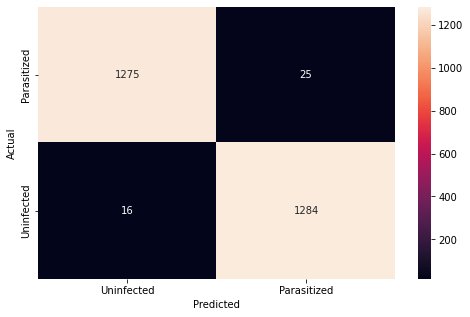

In [24]:
#Plotting Confusion Matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model_1.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_label, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', 
            xticklabels = ['Uninfected', 'Parasitized'], 
            yticklabels = ['Parasitized', 'Uninfected'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

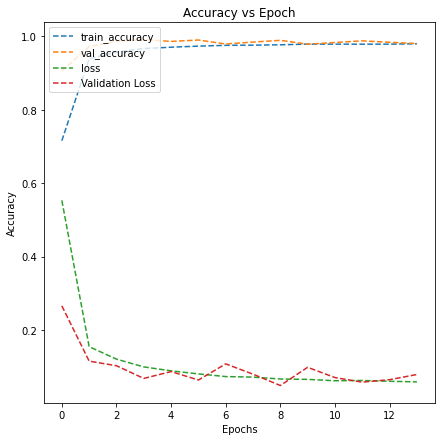

In [25]:
#Plotting training and validation curves
# Function to plot train and validation accuracy 
def plot_accuracy(history_1):
    N = len(history.history["accuracy"])
    plt.figure(figsize = (7, 7))
    plt.plot(np.arange(0, N), history.history["accuracy"], 
             label = "train_accuracy", ls = '--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], 
             label = "val_accuracy", ls = '--')
    plt.plot(np.arange(0, N), history.history["loss"], 
             label = "loss", ls = '--')
    plt.plot(np.arange(0, N), history.history["val_loss"], 
             label = "Validation Loss", ls = '--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

plot_accuracy(history_1)

###<b>Observations:</b><br>
Adding layers to the model has improved overall performance as compared to the base model.  The confusion matrix supports the plot showing accuracy across epochs with 98% precision, recall, and F1 score.  
* The predicted infected cells are only three samples higher than the actual from this model.  This is better precision than seen in the base model.  
* Overfitting is not observed in the model suggesting the Dropout Layer was successful in preventing overfitting of the model to the data.
*  The model performance can be further improved through use of the LeakyRelu function.  The LeakyReLU function leaks small positive samples close to zero allowing additional balance.  As the ReLU values approach zero the model learning rate slows, and no additional performance is achieved.  Through the random leaking of values close to zero the model can continue to learn and improve recall.
*  Adding Batch Normalization will use the mean and variance to normalize the data, shifting the distribution close to the actual values with each epoch.

### **Model 2**
To expand on the previous model, the batch size will be increased to 128 images per batch which leverages more compute engine use to improve model performance.  
* Increase the kernel size to a 3x3, a larger kernel size will reduce the compute power used by increasing the batch size.
* Change the activation to a LeakyRelu to improve model performance, balancing the data.
* Add a Batch Normalization layer to shift the distribution closer to Normal.

In [26]:
#Model 2
backend.clear_session() # Clearing the backend for new model

In [27]:
#Building the Model
def cnn_model_2():
  model = Sequential()
  #First Convolutional Layer
  model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                   padding = "same", 
                   activation = "leaky_relu", 
                   input_shape = (64, 64, 3)))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.2))
  #Second Convolutional Layer
  model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                   padding = "same", activation = "leaky_relu"))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.2))
  #Third Convolutional Layer
  model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                   padding = "same", activation = "leaky_relu"))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.2))
  #Fourth Convolutional Layer
  model.add(Conv2D(filters = 64, kernel_size = (3,3), 
                   padding = "same", activation = "leaky_relu"))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.2))
  
  #Add a BatchNormalization Layer
  model.add(tf.keras.layers.BatchNormalization())
  #Flatten previous layer
  model.add(Flatten())
  #Add Density Layer
  model.add(Dense(512, activation = "leaky_relu"))
  model.add(Dropout(0.4))
  
  #Output Layer
  model.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

  #Compile
  model.compile(
      loss = 'binary_crossentropy', 
      optimizer = 'adam',
      metrics = ['accuracy'])
  return model

#Build the model
model_2=cnn_model_2()

#Print Model Summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

In [28]:
#Callbacks will help us in saving our checkpoints and stopping at an accuracy where the model doesnot seem to improve
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

In [29]:
#Fit and Train Model
history_2 = model_2.fit(train_images, 
                    train_label, 
                    batch_size = 128, 
                    callbacks = callbacks, 
                    validation_split = 0.2, 
                    epochs = 20, 
                    verbose = 1)

Epoch 1/20
156/156 [==============================] - 136s 864ms/step - loss: 0.5941 - accuracy: 0.6989 - val_loss: 0.7203 - val_accuracy: 0.1815
Epoch 2/20
156/156 [==============================] - 131s 837ms/step - loss: 0.1404 - accuracy: 0.9479 - val_loss: 0.7393 - val_accuracy: 0.3958
Epoch 3/20
156/156 [==============================] - 134s 860ms/step - loss: 0.0979 - accuracy: 0.9665 - val_loss: 0.0876 - val_accuracy: 0.9894
Epoch 4/20
156/156 [==============================] - 130s 836ms/step - loss: 0.0854 - accuracy: 0.9709 - val_loss: 0.0379 - val_accuracy: 0.9932
Epoch 5/20
156/156 [==============================] - 134s 858ms/step - loss: 0.0803 - accuracy: 0.9731 - val_loss: 0.0918 - val_accuracy: 0.9822
Epoch 6/20
156/156 [==============================] - 131s 838ms/step - loss: 0.0762 - accuracy: 0.9747 - val_loss: 0.0507 - val_accuracy: 0.9904
Epoch 7/20
156/156 [==============================] - 136s 875ms/step - loss: 0.0748 - accuracy: 0.9753 - val_loss: 0.0943 -

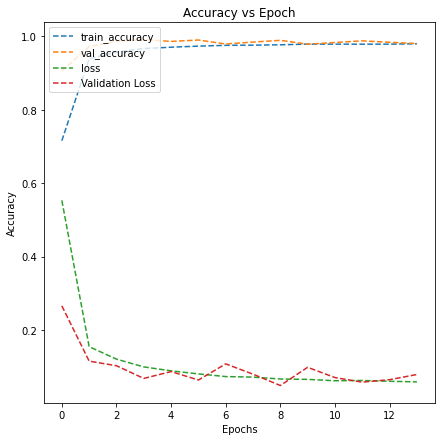

In [30]:
#Function to plot train and validation accuracy 
def plot_accuracy(history_2):
    N = len(history.history["accuracy"])
    plt.figure(figsize = (7, 7))
    plt.plot(np.arange(0, N), history.history["accuracy"], 
             label = "train_accuracy", ls = '--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], 
             label = "val_accuracy", ls = '--')
    plt.plot(np.arange(0, N), history.history["loss"], 
             label = "loss", ls = '--')
    plt.plot(np.arange(0, N), history.history["val_loss"], 
             label = "Validation Loss", ls = '--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

plot_accuracy(history_2)

In [31]:
# Evaluate the model to calculate the accuracy
accuracy_2= model_2.evaluate(test_images, test_label, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 5s 61ms/step - loss: 0.0584 - accuracy: 0.9831

 Test_Accuracy:- 0.9842307567596436


82/82 [==============================] - 7s 81ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1300
           1       0.99      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



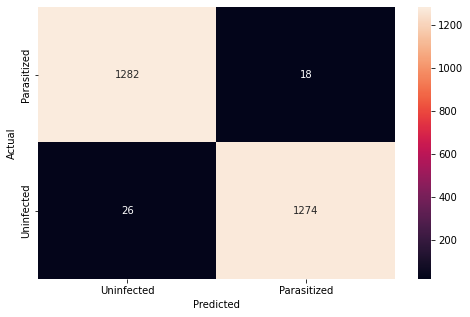

In [32]:
#Generate the classification report and confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model_2.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_label, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', 
            xticklabels = ['Uninfected', 'Parasitized'], 
            yticklabels = ['Parasitized', 'Uninfected'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

###**Observations :**<br>
* The model has improved overall performance as compared to the base model and Model 1.  The confusion matrix supports the plot showing accuracy across epochs with 98% precision, recall, and F1 score.  
* The predicted infected cells are lower than the actual from this model suggesting some samples were marked uninfected but in fact are infected.  The misdiagnosis of eight samples could represent serious negative health outsomes.  While this is the best precision compared to the previously run models, additional work should be performed to prevent false negatives.  
* Overfitting is not observed in the model suggesting the Dropout Layer was successful in preventing overfitting of the model to the data.
*  The model performance is further improved through use of the LeakyRelu function.  
* Batch Normalization was successful normalizing the data with each epoch.

### **Model 3: Image Augmentation**
The previous model assumes the parasite is static in size and shape without variability.  This is not true of the biology of the parasite which changes shape and size throughout the life cycle.  This model should be capable of selecting the parasite from a blood smear at any stage of the life cycle.  This would require training the samples against a variety of possibilities in shape, size, and rotation of the images.  Can the parasite be detected as well if the images are zoomed in, blurring focus?  Can the parasite be detected if the images are rotated?  The ImageDataGenerator allows alteration of the images as a batch method to determine if the changes affect the detection, accuracy, and precision rates.  Rotation, magnification, and horizontal flipping of the image changes the trainable parameters through adjustments to the size and shape of the key features.  


In [33]:
#Model 3 with Data Augmentation
backend.clear_session() # Clearing backend for new model

### Using image data generator

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_label, test_size = 0.2, random_state = 42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(horizontal_flip = True, 
                                  zoom_range = 0.5, rotation_range = 30)
val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size = 64, seed = 42, shuffle = True)

# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x = X_val, y = y_val, batch_size = 64, seed = 42, shuffle = True)

###**Observations :**<br>
The model assumes the parasite is static in size and shape without variability.  This is not true of the biology of the parasite which changes shape and size throughout the life cycle.  This model should be capable of selecting the parasite from a blood smear at any stage of the life cycle.  This would require training the samples against a variety of possibilities in shape, size, and rotation of the images.  Can the parasite be detected as well if the images are zoomed in, blurring focus?  Can the parasite be detected if the images are rotated?  The ImageDataGenerator allows alteration of the images as a batch method to determine if the changes affect the detection, accuracy, and precision rates.

####Visualizing Augmented images

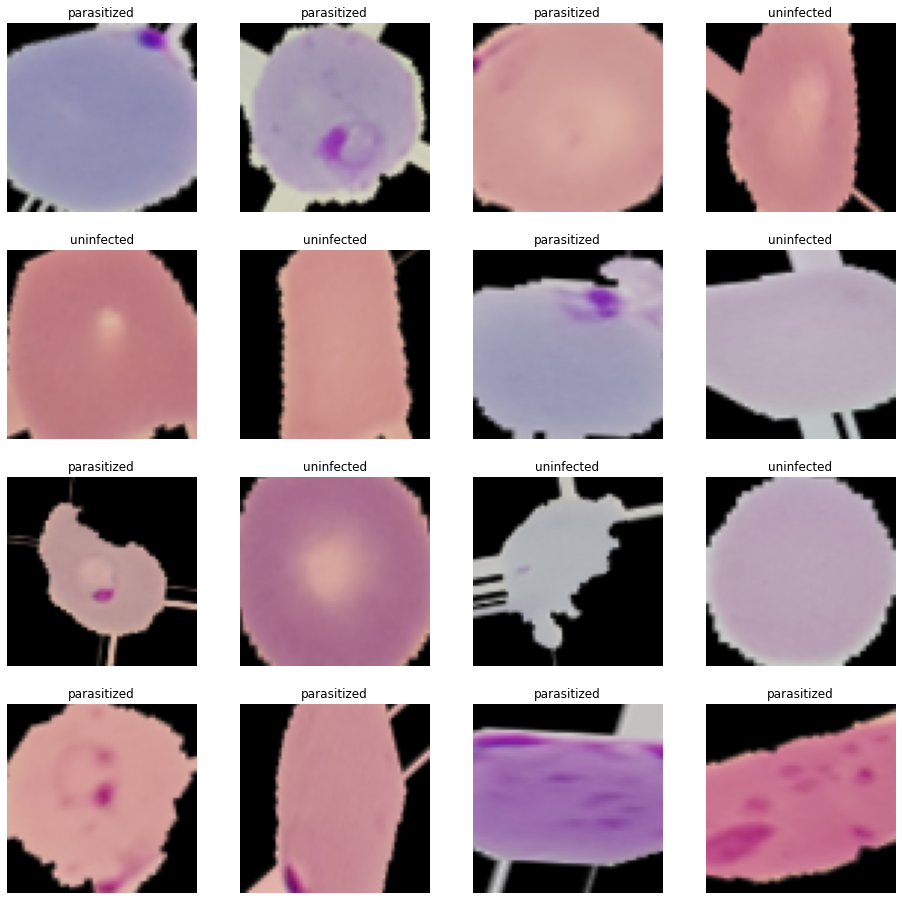

In [35]:
# Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

# Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))

fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label[1] == 1: 
        ax.set_title('parasitized')
    else:
        ax.set_title('uninfected')
    ax.axis('off')

Observations

In [36]:
#Building the Model
def cnn_model_3():
  model = Sequential()
  #First Convolutional Layer
  model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                   padding = "same", 
                   activation = "leaky_relu", 
                   input_shape = (64, 64, 3)))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.2))
  #Second Convolutional Layer
  model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                   padding = "same", activation = "leaky_relu"))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.2))
  #Third Convolutional Layer
  model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                   padding = "same", activation = "leaky_relu"))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.2))
  #Fourth Convolutional Layer
  model.add(Conv2D(filters = 64, kernel_size = (3,3), 
                   padding = "same", activation = "leaky_relu"))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.2))
  
  #Add a BatchNormalization Layer
  model.add(tf.keras.layers.BatchNormalization())
  #Flatten previous layer
  model.add(Flatten())
  #Add Density Layer
  model.add(Dense(512, activation = "leaky_relu"))
  model.add(Dropout(0.4))
  
  #Output Layer
  model.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

  #Compile
  adam = optimizers.Adam(learning_rate = 0.001)
  model.compile(
      loss = 'binary_crossentropy', 
      optimizer = 'adam',
      metrics = ['accuracy'])
  return model

#Build the model
model_3=cnn_model_2()

#Print Model Summary
model_3.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

In [37]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

In [38]:
#Fit and Train Model
history_3 = model_3.fit(train_generator, 
                        validation_data = val_generator,
                        batch_size = 128, 
                        callbacks = callbacks, 
                        validation_split = 0.2, 
                        epochs = 20, 
                        verbose = 1)

Epoch 1/20
312/312 [==============================] - 191s 608ms/step - loss: 0.4966 - accuracy: 0.7528 - val_loss: 0.4690 - val_accuracy: 0.5411
Epoch 2/20
312/312 [==============================] - 197s 630ms/step - loss: 0.1972 - accuracy: 0.9296 - val_loss: 0.0870 - val_accuracy: 0.9756
Epoch 3/20
312/312 [==============================] - 185s 594ms/step - loss: 0.1788 - accuracy: 0.9381 - val_loss: 0.0906 - val_accuracy: 0.9786
Epoch 4/20
312/312 [==============================] - 177s 565ms/step - loss: 0.1705 - accuracy: 0.9432 - val_loss: 0.0725 - val_accuracy: 0.9808
Epoch 5/20
312/312 [==============================] - 181s 580ms/step - loss: 0.1603 - accuracy: 0.9466 - val_loss: 0.0801 - val_accuracy: 0.9784
Epoch 6/20
312/312 [==============================] - 164s 525ms/step - loss: 0.1638 - accuracy: 0.9462 - val_loss: 0.0746 - val_accuracy: 0.9806
Epoch 7/20
312/312 [==============================] - 161s 516ms/step - loss: 0.1527 - accuracy: 0.9499 - val_loss: 0.0765 -

Evaluate the model

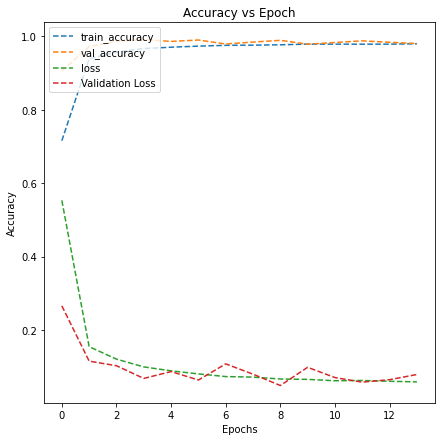

In [39]:
#Function to plot train and validation accuracy 
def plot_accuracy(history_3):
    N = len(history.history["accuracy"])
    plt.figure(figsize = (7, 7))
    plt.plot(np.arange(0, N), history.history["accuracy"], 
             label = "train_accuracy", ls = '--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], 
             label = "val_accuracy", ls = '--')
    plt.plot(np.arange(0, N), history.history["loss"], 
             label = "loss", ls = '--')
    plt.plot(np.arange(0, N), history.history["val_loss"], 
             label = "Validation Loss", ls = '--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

plot_accuracy(history_3)

In [40]:
# Evaluate the model to calculate the accuracy
accuracy_3 = model_3.evaluate(test_images, test_label, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 5s 60ms/step - loss: 0.0593 - accuracy: 0.9804

 Test_Accuracy:- 0.9842307567596436


82/82 [==============================] - 5s 58ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



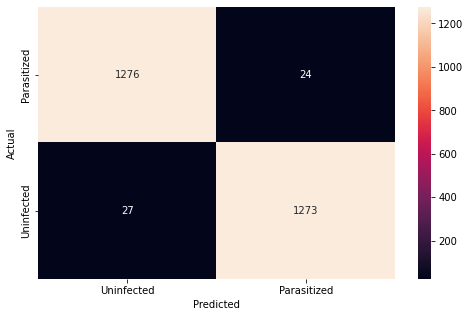

In [41]:
#Generate the classification report and confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model_3.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_label, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', 
            xticklabels = ['Uninfected', 'Parasitized'], 
            yticklabels = ['Parasitized', 'Uninfected'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

###**Observations :**<br>
* The model does not have improved overall performance as compared to the previous models.  The confusion matrix supports the plot showing accuracy across epochs with 99% precision, but reduced to 97% recall, and 98% F1 score.  
* The predicted infected cells are nineteen samples lower than the actual from this model.  This would mean that nineteen positive samples were not correctly identified by the model. 
* The previously designed Model 2 currently performs better than Model 3 but does indicate additional training with rotated, magnified, or other alterations to the image affect the model's ability to predict with the same precision.

### **Model 4: VGG16**

A brief evaluation of  pretrained model like vgg16 performance on our data as compared to the previously trained models.

In [42]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import numpy as np
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path


from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_label, test_size = 0.2, random_state = 42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(horizontal_flip = True, 
                                  zoom_range = 0.5, rotation_range = 30)
val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size = 64, seed = 42, shuffle = True)

# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x = X_val, y = y_val, batch_size = 64, seed = 42, shuffle = True)

vgg = VGG16(include_top = False, 
            weights = 'imagenet', 
            input_shape = (64, 64, 3),
            classifier_activation=None)
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [43]:
#Building the Model
def vgg16_model_4():
  transfer_layer = vgg.get_layer('block5_pool')
  vgg.trainable = False
  # Add classification layers on top of it  
  x = Flatten()(transfer_layer.output)  # Flatten the output from the 3rd block of the VGG16 model
  x = Dense(256, activation = 'relu')(x)

  # Similarly add a dense layer with 128 neurons
  x = Dropout(0.3)(x)
  x = Dense(128, activation = 'relu')(x)

  # Add a dense layer with 64 neurons
  x = BatchNormalization()(x)
  pred = Dense(64, activation = 'softmax')(x)

  # Initializing the model
  model_4 = Model(vgg.input, pred)

  #Compile
  adam = optimizers.Adam(learning_rate = 0.001)
  model.compile(
      loss = 'binary_crossentropy', 
      optimizer = 'adam',
      metrics = ['accuracy'])
  return model

#Build the model
model_4=vgg16_model_4()

#Print Model Summary
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

### Compiling the model 

In [44]:
#Compiling the Model
adam = optimizers.Adam(learning_rate = 0.001)
model_4.compile(
      loss = 'binary_crossentropy', 
      optimizer = 'adam',
      metrics = ['accuracy'])

# Adding Callbacks to the model
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('vgg16_1.h5', monitor='val_loss', save_best_only=True)]

#Fit and Train the Model and running the model for 10 epochs
history_4 = model_4.fit(train_generator, 
                        validation_data = val_generator,
                        batch_size = 128, 
                        callbacks = callbacks, 
                        validation_split = 0.2, 
                        epochs = 20, 
                        verbose = 1)

Epoch 1/20
312/312 [==============================] - 115s 367ms/step - loss: 0.1591 - accuracy: 0.9469 - val_loss: 0.0707 - val_accuracy: 0.9790
Epoch 2/20
312/312 [==============================] - 110s 353ms/step - loss: 0.1552 - accuracy: 0.9452 - val_loss: 0.0673 - val_accuracy: 0.9816
Epoch 3/20
312/312 [==============================] - 111s 357ms/step - loss: 0.1448 - accuracy: 0.9494 - val_loss: 0.0625 - val_accuracy: 0.9818
Epoch 4/20
312/312 [==============================] - 110s 352ms/step - loss: 0.1471 - accuracy: 0.9490 - val_loss: 0.0691 - val_accuracy: 0.9788
Epoch 5/20
312/312 [==============================] - 111s 354ms/step - loss: 0.1456 - accuracy: 0.9518 - val_loss: 0.0607 - val_accuracy: 0.9818
Epoch 6/20
312/312 [==============================] - 115s 368ms/step - loss: 0.1442 - accuracy: 0.9506 - val_loss: 0.0635 - val_accuracy: 0.9810
Epoch 7/20
312/312 [==============================] - 111s 357ms/step - loss: 0.1439 - accuracy: 0.9524 - val_loss: 0.0674 -

In [45]:
# Evaluate the model to calculate the accuracy
accuracy_4 = model_4.evaluate(test_images, test_label, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 3s 40ms/step - loss: 0.0524 - accuracy: 0.9842

 Test_Accuracy:- 0.9842307567596436


In [ ]:
#Function to plot train and validation accuracy 
def plot_accuracy(history_4):
    N = len(history.history["accuracy"])
    plt.figure(figsize = (7, 7))
    plt.plot(np.arange(0, N), history.history["accuracy"], 
             label = "train_accuracy", ls = '--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], 
             label = "val_accuracy", ls = '--')
    plt.plot(np.arange(0, N), history.history["loss"], 
             label = "loss", ls = '--')
    plt.plot(np.arange(0, N), history.history["val_loss"], 
             label = "Validation Loss", ls = '--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

plot_accuracy(history_4)

###**Observations and insights:**
* Test accuracy for the vgg16 model is 98.42%, comparable with the previous model performance.  
*   What can be observed from the validation and train curves?

82/82 [==============================] - 3s 42ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1300
           1       0.99      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



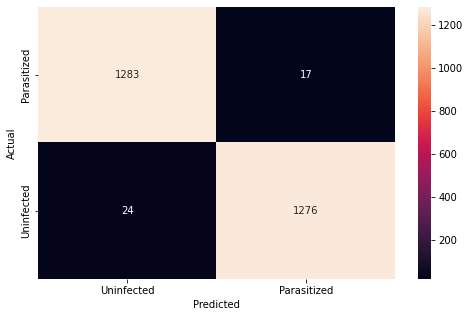

In [48]:
# Plot the confusion matrix and generate a classification report for the model
#Generate the classification report and confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model_4.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_label, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', 
            xticklabels = ['Uninfected', 'Parasitized'], 
            yticklabels = ['Parasitized', 'Uninfected'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Observations and Conclusions drawn from the final model: 
* The confusion matrix shows a high level of accuracy, recall, and F1 score for all models, including the previously trained VGG16 model.  This suggests the parameters to analyze the images for key features appreciates with repeated training.  Combining fine-tuned parameters and utilizing the CNN architecture to maximize key features for the images allows a robust model to be created that is capable of visualizing parasites in blood smears.  This includes augmented images that are rotated, flipped, and magnified.  This suggests the model can be successful with low image quality and images that may have previous processing.  
* Of the models evaluated, Model 2 performed the best with the lowest number of false negatives, highest levels of precision, recall, and accuracy.  It is recommended that Model 2 be adopted as a base for further training with larger data sets.
* The model could be improved by adding a secondary CNN architecture such as the VGG16 following initial training with Model 2.  This may increase the overall precision for the algorithm capturing parasitized images and correctly identifying negative images.

#### Insights
* False negative samples could have serious health outcomes including mortality thus precision and accuracy must match or exceed the accuracy rate of traditional light microscopy.  
* The selected model performs with similar accuracy to traditional techniques used to diagnose Malaria. 
* The VGG16 model demonstrated the importance of well selected layers each working to improve the ability to discern features in image data.  Using the VGG16 model following the proposed Model 2 could improve overall precision, exceeding the precision of traditional light microscopy.



Works Cited
1.    *How to Configure Image Data Augmentation in Keras.* Deep Learning for Computer Vision.  Brownlee J.  https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
2.    *Understanding Data Augmentation | What is Data Augmentation & how it works?*  Great Learning Blog AI and Machine Learning.  Arun K.  https://www.mygreatlearning.com/blog/understanding-data-augmentation/
3.    *Everything you need to know about VGG16.*  Medium.com Blog.  Rohini G.  September 23, 2021.   Everything you need to know about VGG16.
4.    *Step by step VGG16 implementation in Keras for beginners.*  Towards Data Science Blog.  Thakur, Rohit.  August 6, 2019.  Step by step VGG16 implementation in Keras for beginners.
5.     *Very Deep Convolutional Networks for Large-Scale Image Recognition.*  Simonyan, K. and Zisserman, A.  https://arxiv.org/abs/1409.1556.  September 4, 2014.